# Step 3 - TARGET EDA and Modelling
## Goals in this Notebook
- To perform EDA on the application table.
- To construct a viable model for the TARGET feature.
- To enrich the dataset at hand with aggregated features from step 2 and see how that improves the model.
- To select the final model, select the threshold, test the model.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils.constants as constants
import utils.functions as functions
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import PrecisionRecallDisplay, log_loss
from category_encoders import TargetEncoder
import xgboost as xgb
import shap
import pickle
import scikitplot
from joblib import dump

## Load in Data

In [2]:
df_app = pd.read_parquet(r"data\train\df_app.parquet", engine="pyarrow")
df_bur = pd.read_parquet(r"data\train\df_bur.parquet", engine="pyarrow")
df_bur_bal = pd.read_parquet(r"data\train\df_bur_bal.parquet", engine="pyarrow")
df_prev_app = pd.read_parquet(r"data\train\df_prev_app.parquet", engine="pyarrow")
df_cash = pd.read_parquet(r"data\train\df_cash.parquet", engine="pyarrow")
df_inst = pd.read_parquet(r"data\train\df_inst.parquet", engine="pyarrow")
df_cred = pd.read_parquet(r"data\train\df_cred.parquet", engine="pyarrow")

## df_app EDA

In this section, I'll skim through the different types of data in the df_app table.

### TARGET

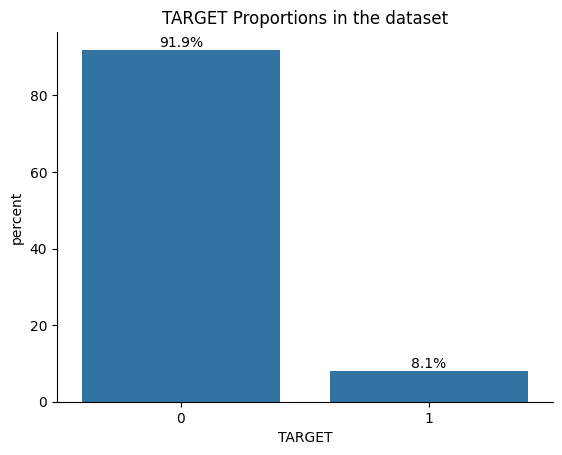

In [3]:
sns.countplot(df_app.fillna(-1), x="TARGET", stat="percent")
functions.add_labels(fmt="%2.1f%%")
plt.title("TARGET Proportions in the dataset")
sns.despine()

Predicting "1" which encodes those having payment difficulties will be challenging as it's a minority class.

### Binary features

We have FLAG_<...> and CODE_GENDER features, which are binary.

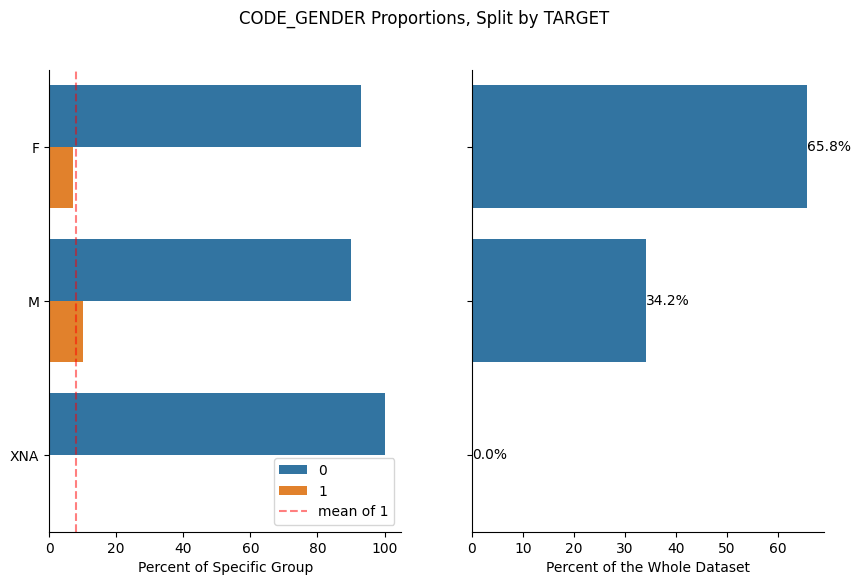

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(df_app.fillna(-1), "CODE_GENDER", "TARGET", ax=ax)
plt.suptitle("CODE_GENDER Proportions, Split by TARGET")
plt.show()

From the above figure, we can see a slight increase in positive TARGET class when we investigate the male population. Another observation - missing values are sometimes encoded as XNA and we have to be aware of that. However, there's also quite

### Categorical Features

There's a lot of categorical values of various cardinality, most of their names start with "NAME", but there are other: ORGANIZATION_TYPE, OCCUPATION_TYPE and a few others.

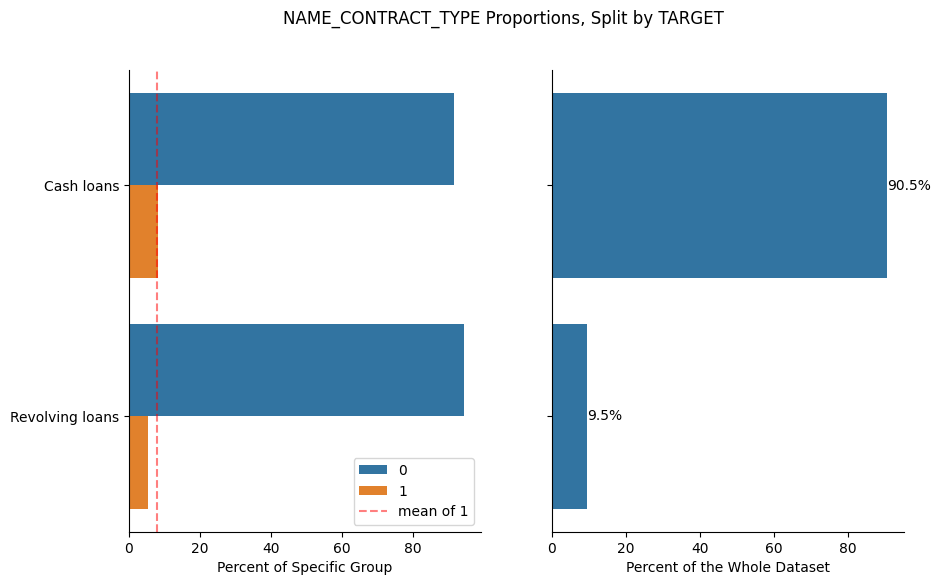

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(df_app.fillna(-1), "NAME_CONTRACT_TYPE", "TARGET", ax=ax)
plt.suptitle("NAME_CONTRACT_TYPE Proportions, Split by TARGET")
plt.show()

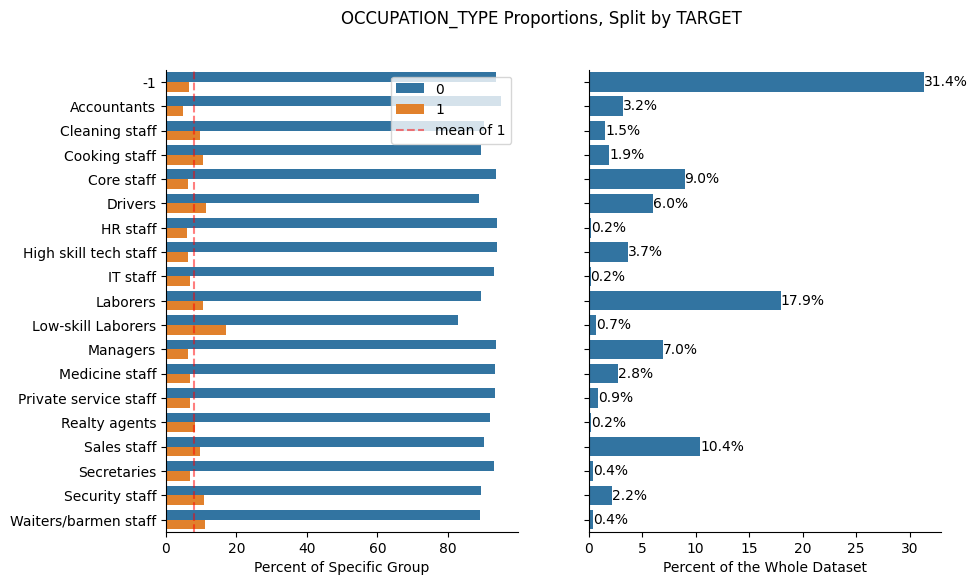

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(df_app.fillna(-1), "OCCUPATION_TYPE", "TARGET", ax=ax)
plt.suptitle("OCCUPATION_TYPE Proportions, Split by TARGET")
plt.show()

The above figure is quite interesting to analyse, as it's immediately obvious that those customers who have lower-skill professions tend to much more frequently be in the positive TARGET class.

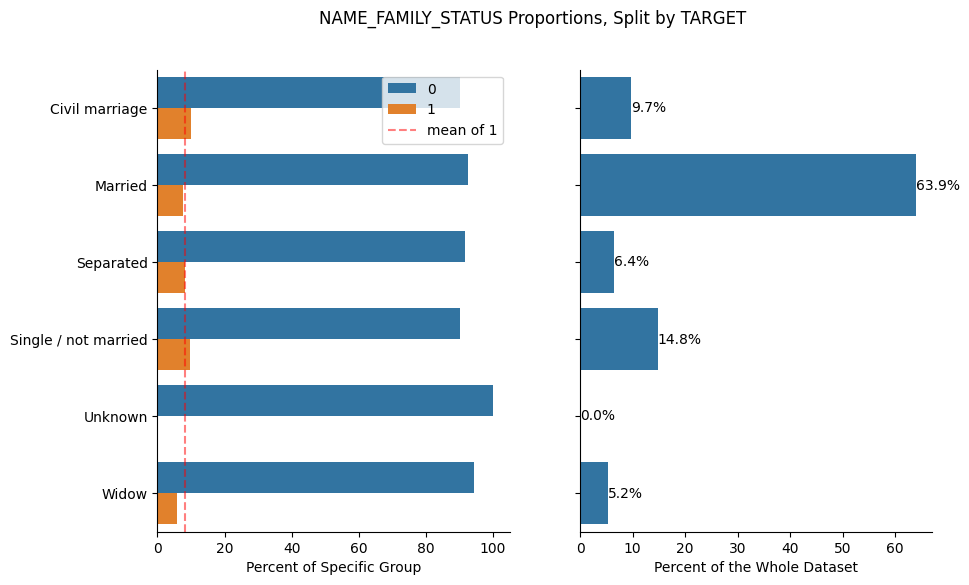

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
functions.norm_plot(df_app.fillna(-1), "NAME_FAMILY_STATUS", "TARGET", ax=ax)
plt.suptitle("NAME_FAMILY_STATUS Proportions, Split by TARGET")
plt.show()

### Ordinal and Continuous Features

There's a lot of features that are either ordinal or categorical. All "AMT...", "EXT_SOURCE...", most of "...AVG", "...MEDI", "...MODE" are continuous. "CNT..." could be called ordinal, as well as "DAYS...".

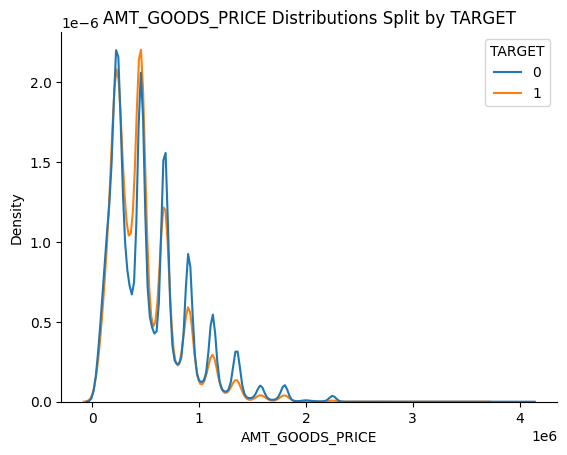

AMT_GOODS_PRICE
False    0.9991
True     0.0009
Name: proportion, dtype: float64

In [8]:
sns.kdeplot(df_app, x="AMT_GOODS_PRICE", hue="TARGET", common_norm=False)
plt.title("AMT_GOODS_PRICE Distributions Split by TARGET")
sns.despine()
plt.show()
df_app["AMT_GOODS_PRICE"].isna().value_counts(normalize=True)

AMT_GOODS_PRICE as well as AMT_CREDIT features have an interesting wavy distribution, and when split by TARGET those with payment problems seem to have a slightly different distribution where the peaks are concerned.

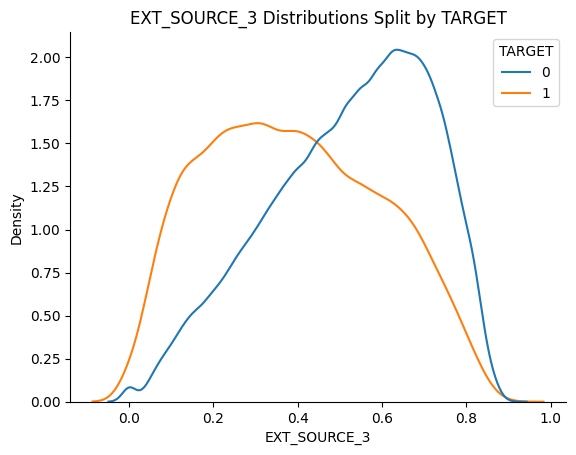

EXT_SOURCE_3
False    0.801626
True     0.198374
Name: proportion, dtype: float64

In [9]:
sns.kdeplot(df_app, x="EXT_SOURCE_3", hue="TARGET", common_norm=False)
plt.title("EXT_SOURCE_3 Distributions Split by TARGET")
sns.despine()
plt.show()
df_app["EXT_SOURCE_3"].isna().value_counts(normalize=True)

The EXT_SOURCE_x features seem to contain risk scores for the customers, and do a good job at separating the two classes.

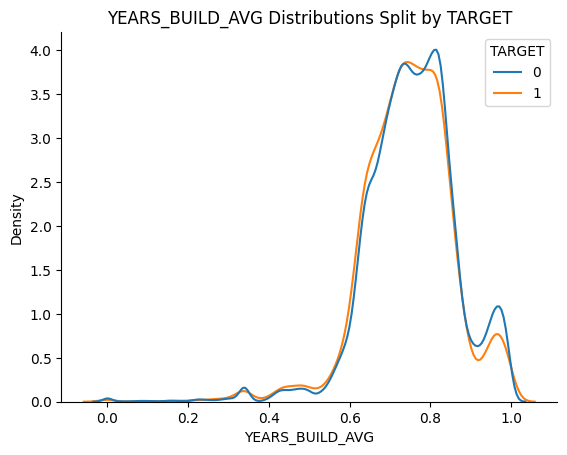

YEARS_BUILD_AVG
True     0.665329
False    0.334671
Name: proportion, dtype: float64

In [10]:
sns.kdeplot(df_app, x="YEARS_BUILD_AVG", hue="TARGET", common_norm=False)
plt.title("YEARS_BUILD_AVG Distributions Split by TARGET")
sns.despine()
plt.show()
df_app["YEARS_BUILD_AVG"].isna().value_counts(normalize=True)

There's a whole lot of the AVG, MEDI, MODE features. The differences between the distributions of the two classes are quite slight, and a lot of the customers don't have a value for these features.

In [11]:
col = "DAYS_EMPLOYED"
(df_app[df_app[col] > 0][col] == 365243).value_counts()

DAYS_EMPLOYED
True    52663
Name: count, dtype: int64

Interestingly, the DAYS features are all non-positive, and the large positive values most likely mean a missing value.

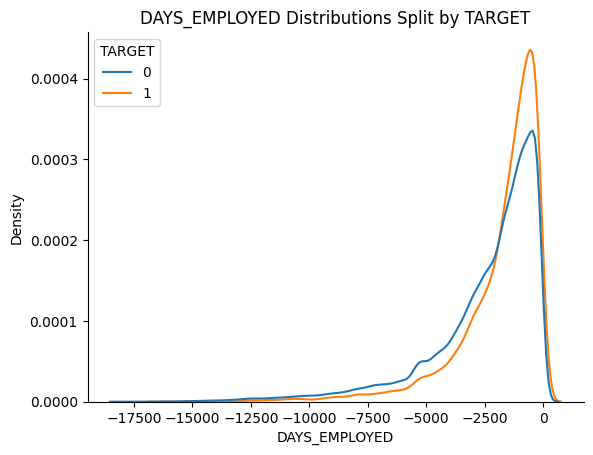

DAYS_EMPLOYED
False    1.0
Name: proportion, dtype: float64

In [12]:
sns.kdeplot(
    df_app[df_app["DAYS_EMPLOYED"] < 1],
    x="DAYS_EMPLOYED",
    hue="TARGET",
    common_norm=False,
)
plt.title("DAYS_EMPLOYED Distributions Split by TARGET")
sns.despine()
plt.show()
df_app["DAYS_EMPLOYED"].isna().value_counts(normalize=True)

Just from the figure above, DAYS_EMPLOYED seems like a fine feature to predict the TARGET, as those that are recently employed tend to more often have issues with their payments.

## Modelling TARGET

### Initial Preprocessor

In [13]:
binary_imputer = SimpleImputer(missing_values="XNA", strategy="most_frequent")
binary_encoder = OneHotEncoder(
    drop="if_binary", handle_unknown="ignore", sparse_output=False
)
binary_pipe = Pipeline(
    [
        ("imputer", binary_imputer),
        ("encoder", binary_encoder),
    ]
)
target_imputer = SimpleImputer(
    missing_values="XNA", strategy="constant", fill_value=None
)
target_encoder = TargetEncoder(handle_missing="value")
target_pipe = Pipeline(
    [
        ("imputer", target_imputer),
        ("encoder", target_encoder),
    ]
)
binary_features = constants.BINARY_COLUMNS_ENCODE
target_features = (
    constants.CATEGORICAL_HIGH_CARDINAL_COLUMNS
    + constants.CATEGORICAL_LOW_CARDINAL_COLUMNS
    + constants.CATEGORICAL_MODE_COLS
)
passthrough_features = (
    constants.BINARY_COLUMNS_PASSTHROUGH
    + constants.CONTINUOUS_COLUMNS
    + constants.ORDINAL_COLUMNS
)
preprocessor = ColumnTransformer(
    [
        ("binary_pipe", binary_pipe, binary_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
        ("drop", "drop", constants.DROP_COLUMNS),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

For better analysis, make days always positive rather than always negative

In [14]:
df_app_days_tf = df_app.copy()
df_app_days_tf[constants.DAYS_COLUMNS] = df_app_days_tf[constants.DAYS_COLUMNS] * -1

X_train_tf, y_train, X_valid_tf, y_valid = functions.preprocess_test_train(
    df_app_days_tf, preprocessor
)

### Modelling on df_app

Since the TARGET feature is in the df_app table, I will need to aggregate other tables into it. First, we can try modelling on the features present in df_app.

Naive log loss baseline - predict each as having the mean probability.

In [15]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
losses = list()
X = df_app_days_tf.drop(columns="TARGET")
y = df_app_days_tf["TARGET"]
for train_idx, eval_idx in cv.split(X, y):
    X_cv_train, y_cv_train = X.iloc[train_idx], y.iloc[train_idx]
    X_cv_eval, y_cv_eval = X.iloc[eval_idx], y.iloc[eval_idx]

    mean_train = y_cv_train.mean()
    y_pred = y_cv_eval.copy().astype(float)
    y_pred.iloc[:] = mean_train

    losses.append(log_loss(y_cv_eval, y_pred))

print(f"baseline log loss: {np.mean(losses):1.3f}")

baseline log loss: 0.280


log loss: 0.247


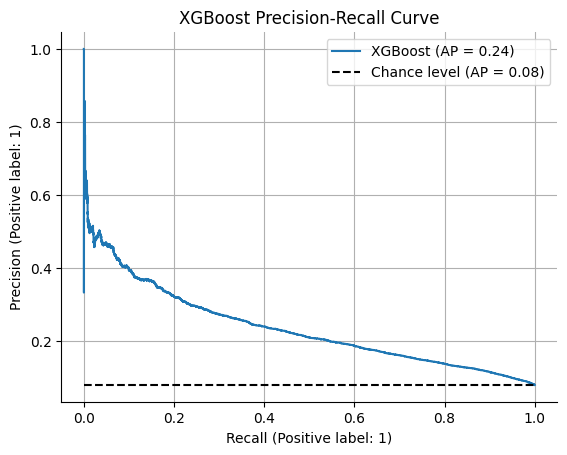

In [16]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.1,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)
functions.report_xgb_metrics(model, X_valid_tf, y_valid, "XGBoost")

We can see that for sure our model is better than random guess. the log loss is better than the baseline (0.280), and achieves average precision (AP) 0.24.

[16:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


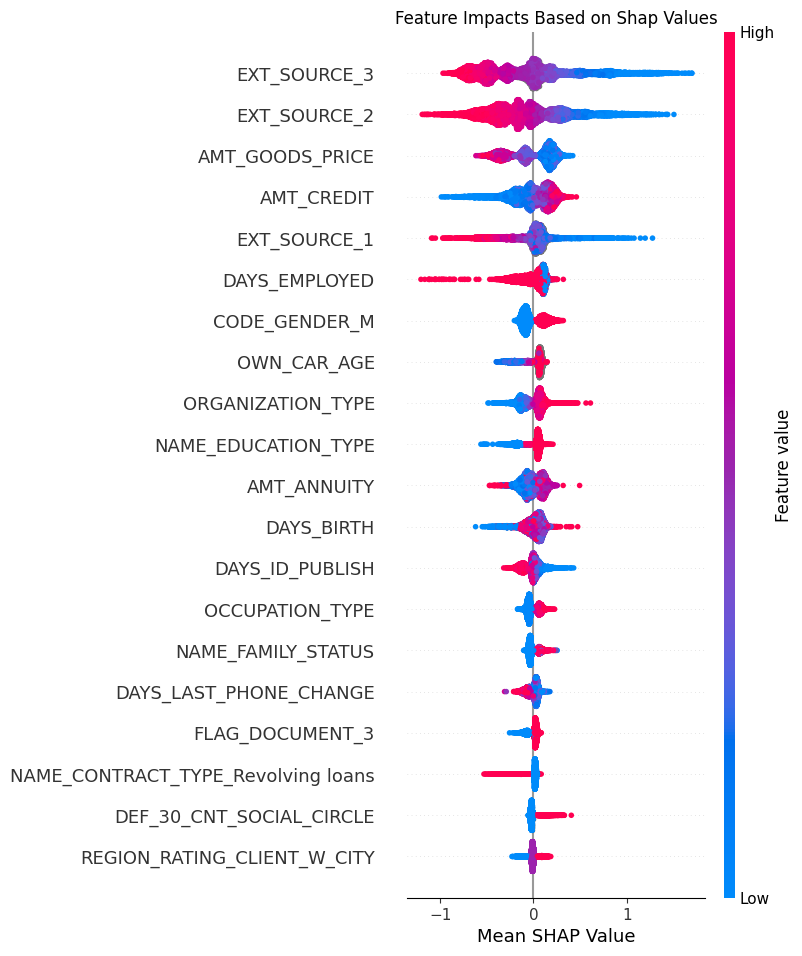

In [17]:
X_valid_tf_sample = X_valid_tf.sample(10000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_valid_tf_sample)

shap.summary_plot(shap_vals, X_valid_tf_sample, show=False)
plt.title("Feature Impacts Based on Shap Values")
plt.xlabel("Mean SHAP Value")
plt.show()

The most important features make sense: 
- Pre-aggregated risk scores "EXT_SOURCE_x" are good indicators of default. 
- Taking loans for cheap goods or taking big loans could indicate payment difficulties.

Interestingly, being male seems to be a good indicator of having payment difficulties.

### Add Bureau Aggregations

Let's continue by adding the bureau aggregations.

In [18]:
aggregates_bur = pd.read_parquet(r"data\train\aggregates_bur.parquet", engine="pyarrow")

BUR_DAYS_COLUMNS = ["bur_DAYS_CREDIT_min", "bur_DAYS_CREDIT_mean"]
aggregates_bur_days_tf = aggregates_bur.copy()
aggregates_bur_days_tf[BUR_DAYS_COLUMNS] = aggregates_bur[BUR_DAYS_COLUMNS] * -1

df_merged = df_app_days_tf.join(aggregates_bur_days_tf, on="SK_ID_CURR")

log loss: 0.245


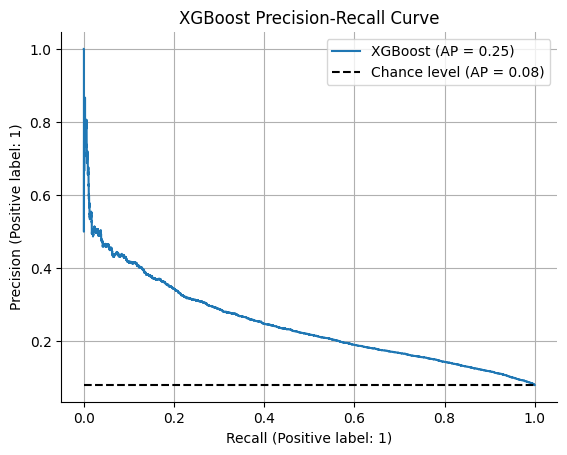

In [19]:
passthrough_features = (
    constants.BINARY_COLUMNS_PASSTHROUGH
    + constants.CONTINUOUS_COLUMNS
    + constants.ORDINAL_COLUMNS
    + aggregates_bur.columns.to_list()
)
preprocessor = ColumnTransformer(
    [
        ("binary_pipe", binary_pipe, binary_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
        ("drop", "drop", constants.DROP_COLUMNS),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

X_train_tf, y_train, X_valid_tf, y_valid = functions.preprocess_test_train(
    df_merged, preprocessor
)

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.1,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)
functions.report_xgb_metrics(model, X_valid_tf, y_valid, "XGBoost")

We get a slightly better model, indicating that some of the aggregations are working.

[16:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


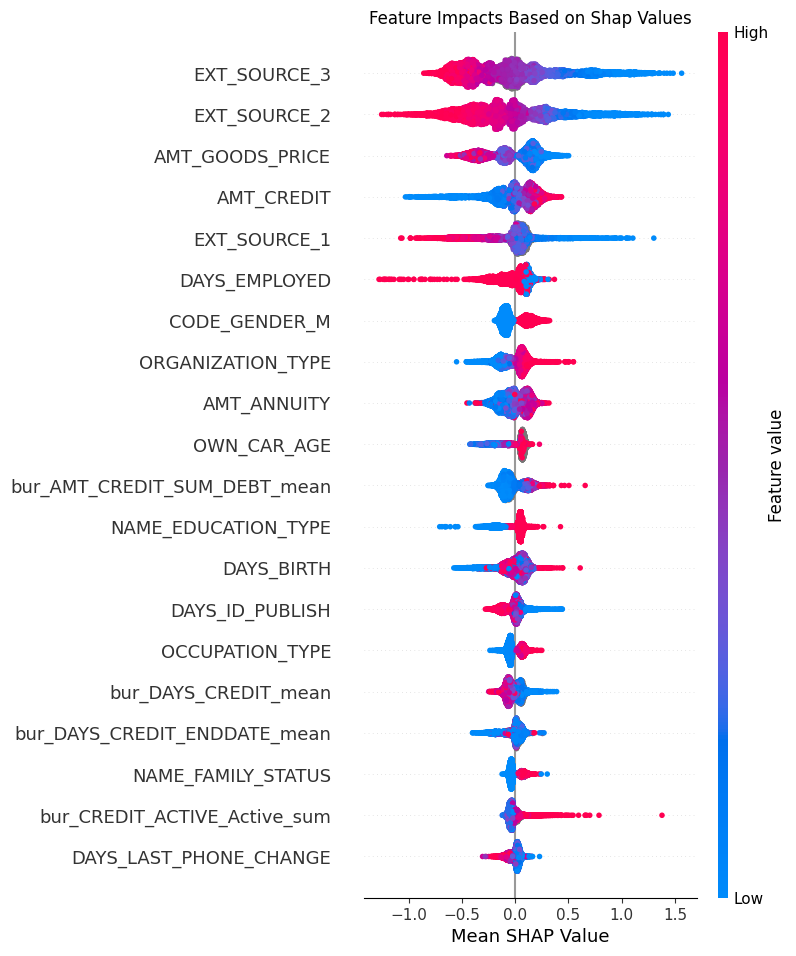

In [20]:
X_valid_tf_sample = X_valid_tf.sample(10000, random_state=42)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_valid_tf_sample)

shap.summary_plot(shap_vals, X_valid_tf_sample, show=False)
plt.title("Feature Impacts Based on Shap Values")
plt.xlabel("Mean SHAP Value")
plt.show()

Indeed, some aggregations are now within the top features.

### Add latest bureau

Let's add more aggregated features from the bureau tables. These aggregations have been made to include data from the last year only.

log loss: 0.244


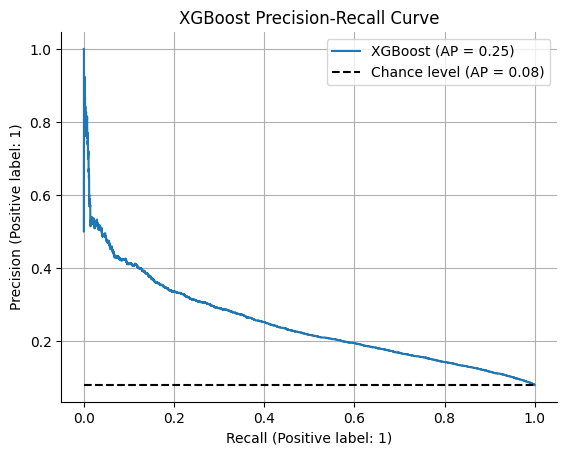

In [21]:
aggregates_latest_bur = pd.read_parquet(
    r"data\train\aggregates_latest_bur.parquet", engine="pyarrow"
)

df_merged = df_merged.join(aggregates_latest_bur, on="SK_ID_CURR")

passthrough_features = (
    constants.BINARY_COLUMNS_PASSTHROUGH
    + constants.CONTINUOUS_COLUMNS
    + constants.ORDINAL_COLUMNS
    + aggregates_bur.columns.to_list()
    + aggregates_latest_bur.columns.to_list()
)
preprocessor = ColumnTransformer(
    [
        ("binary_pipe", binary_pipe, binary_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
        ("drop", "drop", constants.DROP_COLUMNS),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

X_train_tf, y_train, X_valid_tf, y_valid = functions.preprocess_test_train(
    df_merged, preprocessor
)

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.1,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)
functions.report_xgb_metrics(model, X_valid_tf, y_valid, "XGBoost")

Again, a slight increase in performance.

### Boruta for the Features Used so far

We can try reducing the count of features using the boruta algorithm.

In [22]:
# from sklearn.ensemble import RandomForestClassifier
# from boruta import BorutaPy

# np.int = int
# np.float = float
# np.bool = bool
# forest = RandomForestClassifier(
#     max_depth=5
# )
# feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=42)
# feat_selector.fit(X_train_tf.fillna(-100_000_000_000).values, y_train.values)
# feature_ranks = list(zip(X_train_tf.columns,
#                          feat_selector.ranking_,
#                          feat_selector.support_))

# with open("data/boruta_bureau_output.pkl", 'wb') as file:
#     pickle.dump(feature_ranks, file)

with open("data/boruta_bureau_output.pkl", "rb") as file:
    feature_ranks = pickle.load(file)

boruta_importance_df = pd.DataFrame(
    feature_ranks, columns=["col_name", "boruta_rank", "boruta_to_keep"]
)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_valid_tf)
shap_importance_df = functions.get_shap_importance_df(X_valid_tf, shap_vals)

shap_boruta_df = pd.merge(
    shap_importance_df, boruta_importance_df, how="outer", on="col_name"
)
shap_boruta_df.to_excel("data/shap_boruta_compare1.xlsx")

[16:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Upon inspecting the features suggested by boruta and comparing with shap values, I selected to drop a few least important features.

### Add remaining aggregations

Now we know that the aggregations are somewhat working. Lets continue by adding the aggregations from the remaining tables.

In [23]:
aggregates_cash = pd.read_parquet(
    r"data\train\aggregates_cash.parquet", engine="pyarrow"
)
aggregates_cred = pd.read_parquet(
    r"data\train\aggregates_cred.parquet", engine="pyarrow"
)
aggregates_inst = pd.read_parquet(
    r"data\train\aggregates_inst.parquet", engine="pyarrow"
)
aggregates_prev = pd.read_parquet(
    r"data\train\aggregates_prev.parquet", engine="pyarrow"
)

df_merged = (
    df_app_days_tf.join(aggregates_bur_days_tf, on="SK_ID_CURR")
    .join(aggregates_latest_bur, on="SK_ID_CURR")
    .join(aggregates_cash, on="SK_ID_CURR")
    .join(aggregates_cred, on="SK_ID_CURR")
    .join(aggregates_inst, on="SK_ID_CURR")
    .join(aggregates_prev, on="SK_ID_CURR")
)

log loss: 0.239


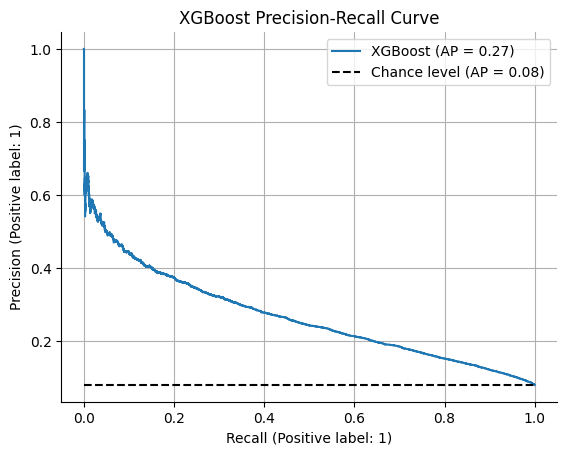

In [24]:
passthrough_features = (
    constants.BINARY_COLUMNS_PASSTHROUGH
    + constants.CONTINUOUS_COLUMNS
    + constants.ORDINAL_COLUMNS
    + aggregates_bur.columns.to_list()
    + aggregates_latest_bur.columns.to_list()
    + aggregates_cash.columns.to_list()
    + aggregates_cred.columns.to_list()
    + aggregates_inst.columns.to_list()
    + aggregates_prev.columns.to_list()
)
preprocessor = ColumnTransformer(
    [
        ("binary_pipe", binary_pipe, binary_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
        ("drop", "drop", constants.DROP_COLUMNS),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

X_train_tf, y_train, X_valid_tf, y_valid = functions.preprocess_test_train(
    df_merged, preprocessor
)
X_train_tf = X_train_tf.drop(columns=constants.DECISION_TO_DROP)
X_valid_tf = X_valid_tf.drop(columns=constants.DECISION_TO_DROP)

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.1,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)
functions.report_xgb_metrics(model, X_valid_tf, y_valid, "XGBoost")

A slight increase in the metrics.

### Boruta for the Merged Data

In [25]:
# from sklearn.ensemble import RandomForestClassifier
# from boruta import BorutaPy

# np.int = int
# np.float = float
# np.bool = bool
# forest = RandomForestClassifier(
#     max_depth=5
# )
# feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=42)
# feat_selector.fit(X_train_tf.fillna(-100_000_000_000).values, y_train.values)
# feature_ranks = list(zip(X_train_tf.columns,
#                          feat_selector.ranking_,
#                          feat_selector.support_))

# with open("data/boruta_combined_output.pkl", 'wb') as file:
#     pickle.dump(feature_ranks, file)

with open("data/boruta_combined_output.pkl", "rb") as file:
    feature_ranks = pickle.load(file)

boruta_importance_df = pd.DataFrame(
    feature_ranks, columns=["col_name", "boruta_rank", "boruta_to_keep"]
)
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_valid_tf)
shap_importance_df = functions.get_shap_importance_df(X_valid_tf, shap_vals)
shap_boruta_df = pd.merge(
    shap_importance_df, boruta_importance_df, how="outer", on="col_name"
)
shap_boruta_df.to_excel("data/shap_boruta_compare2.xlsx")

[16:56:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


log loss: 0.239


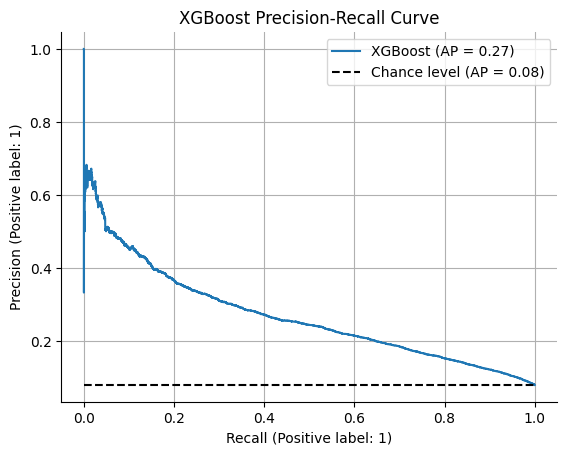

In [26]:
X_train_tf = X_train_tf.drop(columns=constants.DECISION_TO_DROP2)
X_valid_tf = X_valid_tf.drop(columns=constants.DECISION_TO_DROP2)

model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.1,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_valid_tf, y_valid)],
    verbose=0,
)


functions.report_xgb_metrics(model, X_valid_tf, y_valid, "XGBoost")

The feature selection is successful - AP and log loss didn't decrease.

### Greatly Reduced Complexity Model

#### Reducing Complexity to 20 Features

To save on time, I'll be reducing to 20 most important features based on shap values. I developed a sequential shap selector to iteratively select the best 20 features.

In [27]:
REDUCE_TO = 20
print(f"Reducing feature number from {len(X_train_tf.columns)} to {REDUCE_TO}")
# selected_cols = functions.shap_sequentially_select(
#     X_train_tf,
#     y_train,
#     X_valid_tf,
#     y_valid,
#     reduce_to=REDUCE_TO,
# )
# with open("data/columns_20_TARGET.pkl", 'wb') as file:
#     pickle.dump(selected_cols, file)
with open("data/columns_20_TARGET.pkl", "rb") as file:
    selected_cols = pickle.load(file)
X_train_tf_20 = X_train_tf[selected_cols]
X_valid_tf_20 = X_valid_tf[selected_cols]

Reducing feature number from 195 to 20


log loss: 0.243


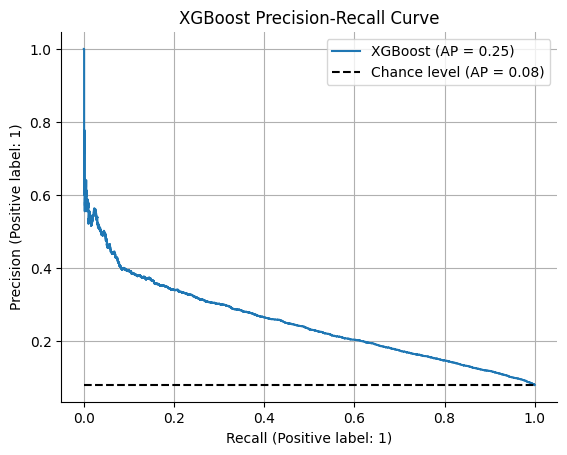

In [28]:
model_20 = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,
    learning_rate=0.1,
    early_stopping_rounds=50,
    seed=42,
    random_state=42,
)
model_20.fit(
    X_train_tf_20,
    y_train,
    eval_set=[(X_valid_tf_20, y_valid)],
    verbose=0,
)
functions.report_xgb_metrics(model_20, X_valid_tf_20, y_valid, "XGBoost")

We can see that model's performance deteriorated: AP dropped from 0.27 to 0.25, log loss increased from 0.239 to 0.243.

[16:58:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


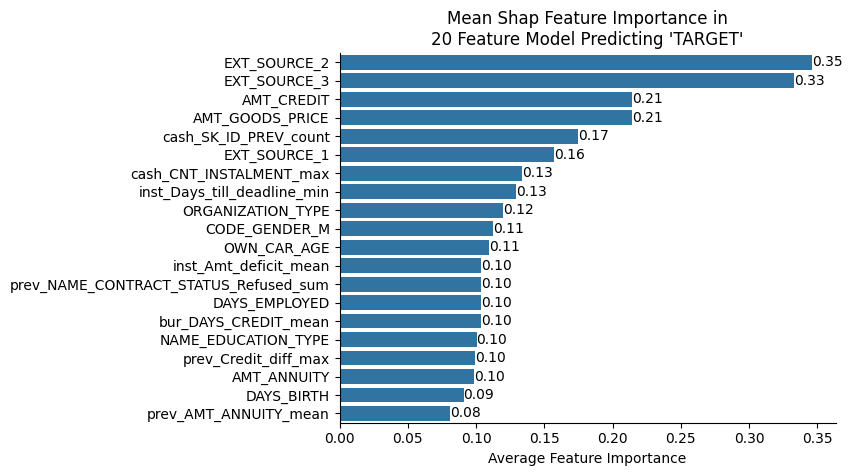

In [29]:
X_valid_tf_sample = X_valid_tf_20.sample(frac=0.2)
explainer = shap.TreeExplainer(model_20)
shap_vals = explainer.shap_values(X_valid_tf_sample)
shap_importance_df = functions.get_shap_importance_df(X_valid_tf_sample, shap_vals)
sns.barplot(shap_importance_df, y="col_name", x="shap_feature_importance")
plt.title("Mean Shap Feature Importance in\n20 Feature Model Predicting 'TARGET'")
plt.xlabel("Average Feature Importance")
plt.ylabel("")
functions.add_labels(fmt="%1.2f")
sns.despine()

In the simplified model, we have a handful of aggregated features, but the most important features are still from the original df_app table. This could indicate that I didn't do a very good job on the aggregations. Creating aggregations based on some latest data could potentially be better.

There are also some concerns about the selection of features: using gender as a feature creates a discriminatory bias towards one gender. There is also a feature that sums how many of previous applications were refused, potentially creating a barrier for new applications.

#### Arrange Data Pipeline and Preprocessor

Let's prepare a complete data pipeline that gathers required features from the tables and also a preprocessor that transforms the features.

In [30]:
df_merged = functions.prepare_data_TARGET_20(
    df_cash, df_inst, df_bur, df_prev_app, df_app
)

Check for duplicates.

In [31]:
df_merged.duplicated().value_counts()

False    292135
Name: count, dtype: int64

In [32]:
binary_imputer = SimpleImputer(missing_values="XNA", strategy="most_frequent")
binary_encoder = OneHotEncoder(
    drop="if_binary", handle_unknown="ignore", sparse_output=False
)
binary_pipe = Pipeline(
    [
        ("imputer", binary_imputer),
        ("encoder", binary_encoder),
    ]
)
target_imputer = SimpleImputer(
    missing_values="XNA", strategy="constant", fill_value=None
)
target_encoder = TargetEncoder(handle_missing="value")
target_pipe = Pipeline(
    [
        ("imputer", target_imputer),
        ("encoder", target_encoder),
    ]
)
binary_features = ["CODE_GENDER"]
target_features = ["ORGANIZATION_TYPE", "NAME_EDUCATION_TYPE"]
passthrough_features = list(
    set(df_merged.columns)
    - set(binary_features)
    - set(target_features)
    - set(["TARGET"])
)
preprocessor = ColumnTransformer(
    [
        ("binary_pipe", binary_pipe, binary_features),
        ("target_pipe", target_pipe, target_features),
        ("passthrough", "passthrough", passthrough_features),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [33]:
X_train_tf, y_train, X_valid_tf, y_valid = functions.preprocess_test_train(
    df_merged, preprocessor
)

#### Tuning

In [34]:
# import optuna
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 0.05, 0.3, log=True),
#         gamma=trial.suggest_float("gamma", 1e-4, 5, log=True),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#         subsample=trial.suggest_float("subsample", 0.5, 1),
#         objective="binary:logistic",
#         n_estimators=1000,
#         early_stopping_rounds=20,
#         random_state=42,
#         seed=42,
#     )
#     model = xgb.XGBClassifier(**xgb_params)
#     cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     losses = list()
#     X = df_merged.drop(columns="TARGET")
#     y = df_merged["TARGET"]
#     preprocessor_cv = ColumnTransformer(
#         [
#             ("binary_pipe", binary_pipe, binary_features),
#             ("target_pipe", target_pipe, target_features),
#             ("passthrough", "passthrough", passthrough_features),
#         ],
#         verbose_feature_names_out=False,
#     )
#     for train_idx, eval_idx in cv.split(X, y):
#         X_cv_train, y_cv_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_cv_eval, y_cv_eval = X.iloc[eval_idx], y.iloc[eval_idx]

#         X_cv_train_tf = preprocessor_cv.fit_transform(X_cv_train, y_cv_train)
#         X_cv_eval_tf = preprocessor_cv.transform(X_cv_eval)
#         model.fit(
#             X_cv_train_tf, y_cv_train, eval_set=[(X_cv_eval_tf, y_cv_eval)], verbose=0
#         )
#         losses.append(model.best_score)
#     return np.mean(losses)

# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(objective, n_trials=100, n_jobs=-1)
# xgb_params = study.best_params
# with open("data/TARGET_xgbparams.pkl", "wb") as file:
#     pickle.dump(xgb_params, file)

with open("data/TARGET_xgbparams.pkl", "rb") as file:
    xgb_params = pickle.load(file)
xgb_params

{'max_depth': 4,
 'learning_rate': 0.06300340890386036,
 'gamma': 0.19547111431304742,
 'min_child_weight': 8,
 'reg_alpha': 0.0012557565375843768,
 'reg_lambda': 2.8198700155340966,
 'subsample': 0.7630281344210769}

log loss: 0.242


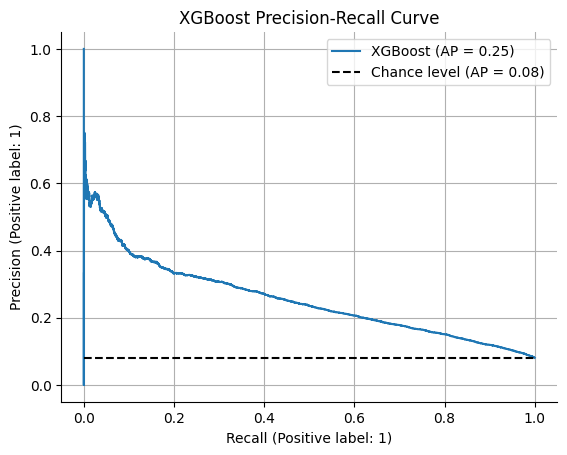

In [35]:
model_tuned = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    early_stopping_rounds=20,
    seed=42,
    random_state=42,
    **xgb_params
)
model_tuned.fit(
    X_train_tf,
    y_train,
    eval_set=[(X_train_tf, y_train), (X_valid_tf, y_valid)],
    verbose=0,
)
functions.report_xgb_metrics(model_tuned, X_valid_tf, y_valid, "XGBoost")

The tuned model is only slightly better than the previous - log loss decreased by 0.001.

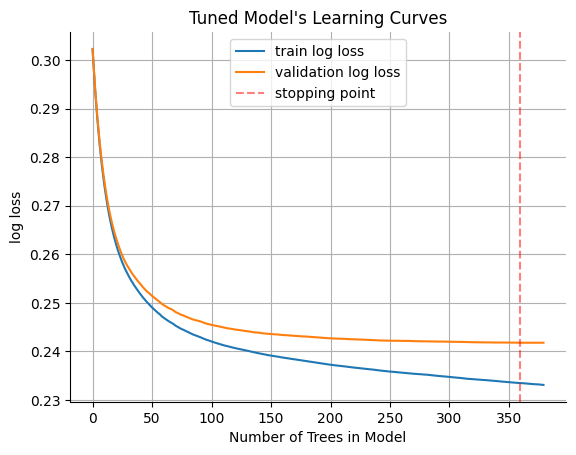

In [36]:
results = model_tuned.evals_result()
fig, ax = plt.subplots()
ax.plot(
    results["validation_0"]["logloss"],
    label="train log loss",
)
ax.plot(
    results["validation_1"]["logloss"],
    label="validation log loss",
)
ax.axvline(
    model_tuned.best_iteration, color="red", alpha=0.5, ls="--", label="stopping point"
)
ax.legend()
plt.title("Tuned Model's Learning Curves")
plt.ylabel("log loss")
plt.xlabel("Number of Trees in Model")
plt.grid()
sns.despine()

The model has early stopped, reaching its top performance.

[16:58:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


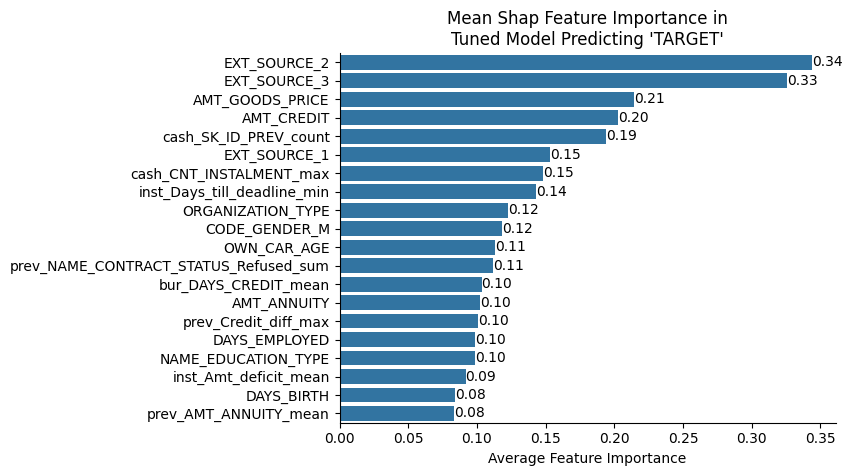

In [37]:
X_valid_tf_sample = X_valid_tf.sample(frac=0.2)
explainer = shap.TreeExplainer(model_tuned)
shap_vals = explainer.shap_values(X_valid_tf_sample)
shap_importance_df = functions.get_shap_importance_df(X_valid_tf_sample, shap_vals)
sns.barplot(shap_importance_df, y="col_name", x="shap_feature_importance")
plt.title("Mean Shap Feature Importance in\nTuned Model Predicting 'TARGET'")
plt.xlabel("Average Feature Importance")
plt.ylabel("")
functions.add_labels(fmt="%1.2f")
sns.despine()

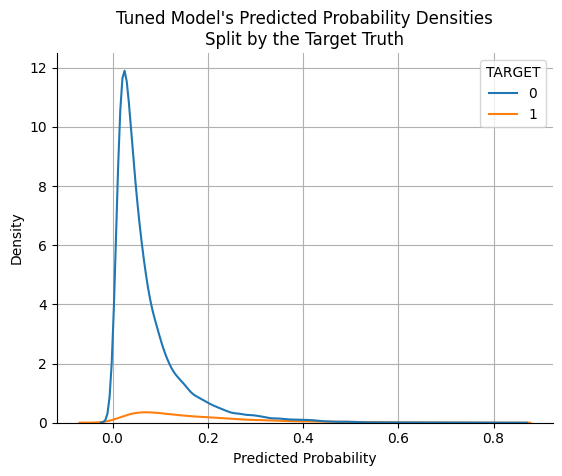

In [38]:
pred_proba = model_tuned.predict_proba(X_valid_tf)
proba_ser = pd.Series(pred_proba[:, 1], name="proba")
target_df = y_valid.reset_index()
target_df = target_df.join(proba_ser)
sns.kdeplot(target_df, x="proba", hue="TARGET")
plt.grid()
plt.title("Tuned Model's Predicted Probability Densities\nSplit by the Target Truth")
plt.xlabel("Predicted Probability")
sns.despine()

In [39]:
target_df.groupby("TARGET")["proba"].describe()

,count,mean,std,min,25%,50%,75%,max
TARGET,,,,,,,,
0,53713.0,0.072916,0.076062,0.001659,0.025321,0.047062,0.090868,0.844434
1,4714.0,0.170790,0.133194,0.004142,0.071192,0.133764,0.232522,0.803612


The Densities don't seem separable. The peaks are in a similar location, however the quantiles of the positive class are greater than the negative class, which still indicates that the model can be useful.

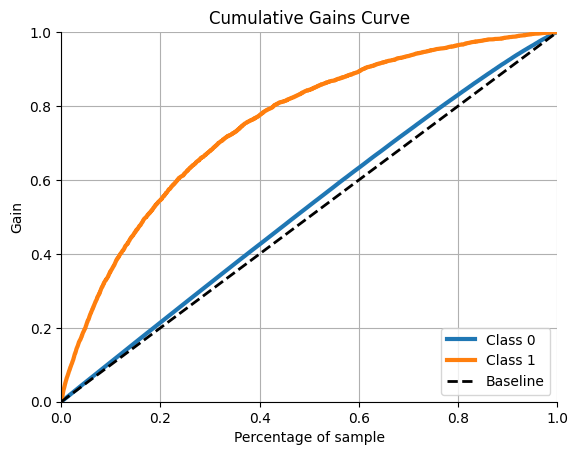

In [40]:
scikitplot.metrics.plot_cumulative_gain(y_valid, pred_proba)
sns.despine()

By investigating 20% of the most likely positive examples, we would find that around 50% are actually positive. That seems like an OK result.

#### Calculating optimal Threshold

Based on https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28,<br>
it's good to adjust the threshold based on the cost of Type I error (P10) and Type II error (P01).

Making a type I error would mean labelling a customer as having payment difficulties when they actually don't. For the business it would mean rejecting an application that shouldn't have been rejected and loosing on the income from that account.<br>
Making a type II error would cause approving an application that shouldn't have been approved. This could cause losing a portion of the credit issued to the account or even the full amount.

Let's assume that type II error is 4x as bad as a type I error. With this assumption we can calculate the threshold:<br>
p - probability of default output from our model.<br>
P10 - cost of Type I error.<br>
P01 - cost of Type II error.<br>
From our assumption, P10 = 1, P01 = 4.

Then, we would label a customer as potentially having payment difficulties when:<br>
p x P01 > (1 - p) x P10<br>
rearranges to <br>
p > P10 / (P01 + P10)<br>
in our case<br>
p > 1/5

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     53713
           1       0.30      0.32      0.31      4714

    accuracy                           0.88     58427
   macro avg       0.62      0.63      0.62     58427
weighted avg       0.89      0.88      0.89     58427



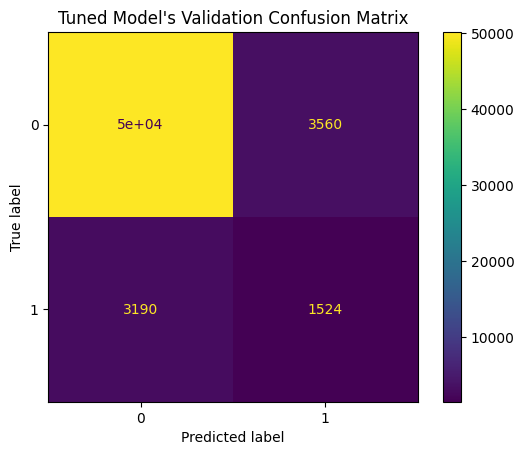

In [41]:
SELECTED_THRESHOLD = 0.2
preds = np.where(pred_proba[:, 1] > SELECTED_THRESHOLD, 1, 0)
functions.report_classification_metrics(y_valid, preds)
plt.title("Tuned Model's Validation Confusion Matrix")
plt.show()

Using this method, we can see that the errors are balanced even though we said that type II error is 4x as bad.

Because of this, Let's try calculating the threshold in another way, where Ixy is Income from a predicted x true y element in the confusion matrix:<br>
I00 = 0.2 (we gain the income from the account)<br>
I11 = 0 (we correctly reject, not losing any of the credit)<br>
I01 = -0.8 (assume that we lose 80% of the credit)<br>
I10 = -0.2 (we incorrectly reject losing potential income. From assumption, P10 = P01/4)

In [42]:
profit_dict = dict()
for thresh in np.arange(0, 1, 0.01):
    preds_loop = np.where(pred_proba[:, 1] > thresh, 1, 0)
    profit = functions.calculate_profit_TARGET(y_valid, preds_loop)
    profit_dict[thresh] = profit
profit_ser = pd.Series(profit_dict)
PROFITABLE_THRESHOLD = profit_ser.index[profit_ser.argmax()]

best_profit = profit_ser.loc[PROFITABLE_THRESHOLD]
prev_profit = profit_ser.loc[SELECTED_THRESHOLD]
profit_increase = best_profit * 100 / prev_profit - 100
print(
    f"With previous threshold of {SELECTED_THRESHOLD}, the potential income would be {prev_profit:.2f} comparison units."
)
print(
    f"With the new threshold of {PROFITABLE_THRESHOLD}, the potential income would be {best_profit:.2f} comparison units."
)
print(f"That's a {profit_increase:2.2f}% increase in profit.")

With previous threshold of 0.2, the potential income would be 6766.60 comparison units.
With the new threshold of 0.42, the potential income would be 7076.20 comparison units.
That's a 4.58% increase in profit.


              precision    recall  f1-score   support

           0       0.92      0.99      0.96     53713
           1       0.47      0.06      0.11      4714

    accuracy                           0.92     58427
   macro avg       0.70      0.53      0.53     58427
weighted avg       0.89      0.92      0.89     58427



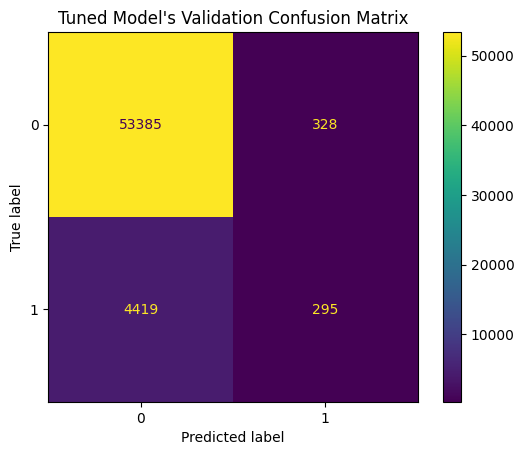

In [43]:
preds = np.where(pred_proba[:, 1] > PROFITABLE_THRESHOLD, 1, 0)
functions.report_classification_metrics(y_valid, preds)
plt.title("Tuned Model's Validation Confusion Matrix")
plt.show()

With this new selected threshold, our model doesn't do much. When using the new imposed income/cost matrix, it seems profitable to use the model only when it's fairly certain about the output. 

All in all, the model does not seem to do a very good job - accuracy seems decent, but any prediction about the minority class seems to be tough. Calculating better aggregations from the tables at hand should be the best way to make the model better.

### Retrain Selected Model on the Whole Dataset

In [44]:
X_train = df_merged.drop(columns=["TARGET"])
y_train = df_merged["TARGET"]

X_train_tf = preprocessor.fit_transform(X_train, y_train)

n_estimators = model_tuned.best_iteration

model_retrained = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=n_estimators,
    seed=42,
    random_state=42,
    **xgb_params
)
model_retrained.fit(
    X_train_tf,
    y_train,
    verbose=0,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.19547111431304742, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06300340890386036,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=359, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [45]:
dump(preprocessor, "app_TARGET/models/TARGET_preprocessor_V1.joblib")

['app_TARGET/models/TARGET_preprocessor_V1.joblib']

In [46]:
dump(model_retrained, "app_TARGET/models/TARGET_model_V1.joblib")

['app_TARGET/models/TARGET_model_V1.joblib']

### Selected Model Testing

In [47]:
df_app_test = pd.read_parquet(r"data\test\df_app.parquet", engine="pyarrow")
df_bur_test = pd.read_parquet(r"data\test\df_bur.parquet", engine="pyarrow")
df_prev_app_test = pd.read_parquet(r"data\test\df_prev_app.parquet", engine="pyarrow")
df_cash_test = pd.read_parquet(r"data\test\df_cash.parquet", engine="pyarrow")
df_inst_test = pd.read_parquet(r"data\test\df_inst.parquet", engine="pyarrow")

df_merged_test = functions.prepare_data_TARGET_20(
    df_cash_test, df_inst_test, df_bur_test, df_prev_app_test, df_app_test
)

X_test = df_merged_test.drop(columns=["TARGET"])
y_test = df_merged_test["TARGET"]

X_test_tf = preprocessor.transform(X_test)

log loss: 0.243


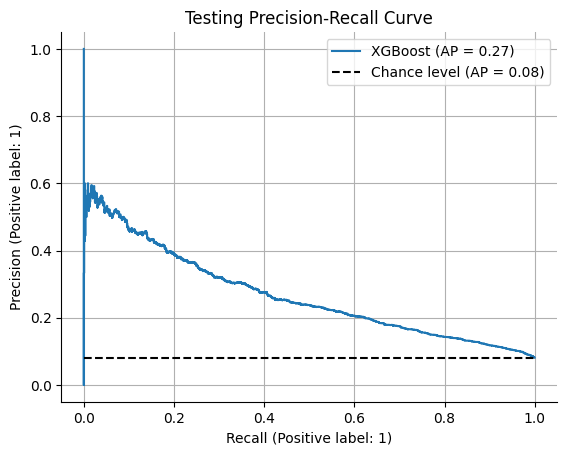

In [48]:
pred_proba = model_retrained.predict_proba(X_test_tf)

loss = log_loss(y_test, pred_proba[:, 1])
print(f"log loss: {loss:1.3f}")
disp = PrecisionRecallDisplay.from_estimator(
    model_retrained, X_test_tf, y_test, name="XGBoost", plot_chance_level=True
)
_ = disp.ax_.set_title(f"Testing Precision-Recall Curve")
plt.legend(loc=1)
plt.grid()
sns.despine()

Comparing to validation log loss of 0.242 and AP 0.25, testing look quite successful.

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     14122
           1       0.50      0.06      0.11      1254

    accuracy                           0.92     15376
   macro avg       0.71      0.53      0.53     15376
weighted avg       0.89      0.92      0.89     15376



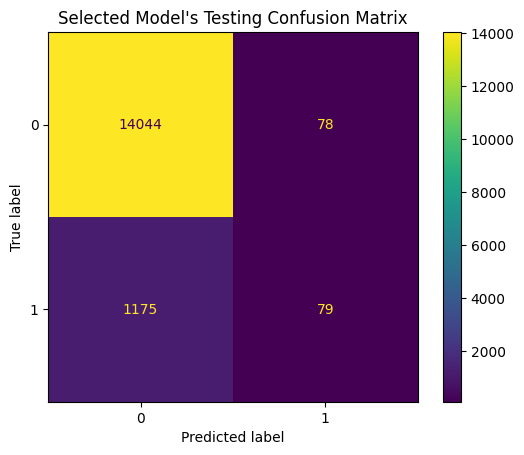

In [49]:
preds = np.where(pred_proba[:, 1] > PROFITABLE_THRESHOLD, 1, 0)
functions.report_classification_metrics(y_test, preds)
plt.title("Selected Model's Testing Confusion Matrix")
plt.show()

Confusion matrix and classification report also look similar to that of validation.

## Output From This Notebook

In this notebook, we have:
- Done EDA on the application table.
- Enriched the dataset with aggregate features and created a reduced complexity model to predict TARGET.
- Selected optimal threshold following business assumptions.
- Tested the model.

Areas to improve:
- Cycle back to feature engineering, explore aggregations that use only the latest few statuses.
- Explore more areas of feature engineering, especially ratios, ie the mean of all three EXT_SOURCE features.
- Deploy the model. This would most likely require setting up a dynamic database with all the tables.